In [7]:
import face_recognition
import cv2
import os
import csv
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [8]:
# Image Preprocessing Function
def img_resize(img, width=150):  # Increase resolution to 150x150
    (h, w) = img.shape[:2]
    ratio = width / float(w)
    height = int(h * ratio)
    return cv2.resize(img, (width, height))

In [9]:
# Add Noise to Images
def add_noise(img):
    noise = np.random.randint(0, 30, img.shape, dtype='uint8')  # Reduce noise intensity
    return cv2.add(img, noise)

In [10]:
# Load Encodings from a Folder with Limited Images
def load_encodings(folder, limit=20):  # Increase training data to 20 images per folder
    encodings = []
    labels = []
    if not os.path.exists(folder):
        print(f"Folder '{folder}' does not exist!")
        return encodings, labels

    for person_name in os.listdir(folder):
        person_path = os.path.join(folder, person_name)
        if not os.path.isdir(person_path):
            continue

        files = os.listdir(person_path)
        random.shuffle(files)  # Shuffle images for randomness
        for file in files[:limit]:  # Limit to 'limit' images per person
            img_path = os.path.join(person_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = img_resize(img)
            img_enc = face_recognition.face_encodings(img)
            if img_enc:
                encodings.append(img_enc[0])
                labels.append(person_name)  # Use folder name as label
    return encodings, labels

In [11]:
# Attendance Logger
def mark_attendance(name):
    file_path = 'attendance.csv'
    logged_names = set()

    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            reader = csv.reader(file)
            logged_names = {row[0] for row in reader}

    if name not in logged_names:
        with open(file_path, 'a', newline='') as file:
            writer = csv.writer(file)
            now = datetime.now()
            time_string = now.strftime('%Y-%m-%d %H:%M:%S')
            writer.writerow([name, time_string])

In [12]:
# Load Training and Testing Data
train_enc, train_labels = load_encodings('train', limit=20)  # Use 20 images per folder
test_enc, test_labels = load_encodings('test', limit=15)  # Keep test set at 15 images per folder

In [13]:
# Test Accuracy and Metrics Calculation
true_labels = []
predicted_labels = []
correct_predictions = 0
true_positives = 0
false_positives = 0
false_negatives = 0
all_distances = []

for enc, label in zip(test_enc, test_labels):
    noisy_enc = enc + np.random.normal(0, 0.02, size=enc.shape)  # Slight noise to test encodings
    matches = face_recognition.compare_faces(train_enc, noisy_enc)
    distances = face_recognition.face_distance(train_enc, noisy_enc)
    all_distances.extend(distances)
    best_match_index = distances.argmin() if matches else -1

    predicted_label = train_labels[best_match_index] if best_match_index != -1 and distances[best_match_index] < 0.65 else "Unknown"
    
    # Track for confusion matrix
    true_labels.append(label)
    predicted_labels.append(predicted_label)

    if predicted_label == label:
        true_positives += 1
        correct_predictions += 1
    elif predicted_label != "Unknown":
        false_positives += 1
    else:
        false_negatives += 1

In [14]:
# Compute metrics
test_accuracy = (correct_predictions / len(test_labels)) * 100 if test_labels else 0
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

Test Accuracy: 95.41%
Precision: 0.95
Recall: 1.00
F1-Score: 0.98


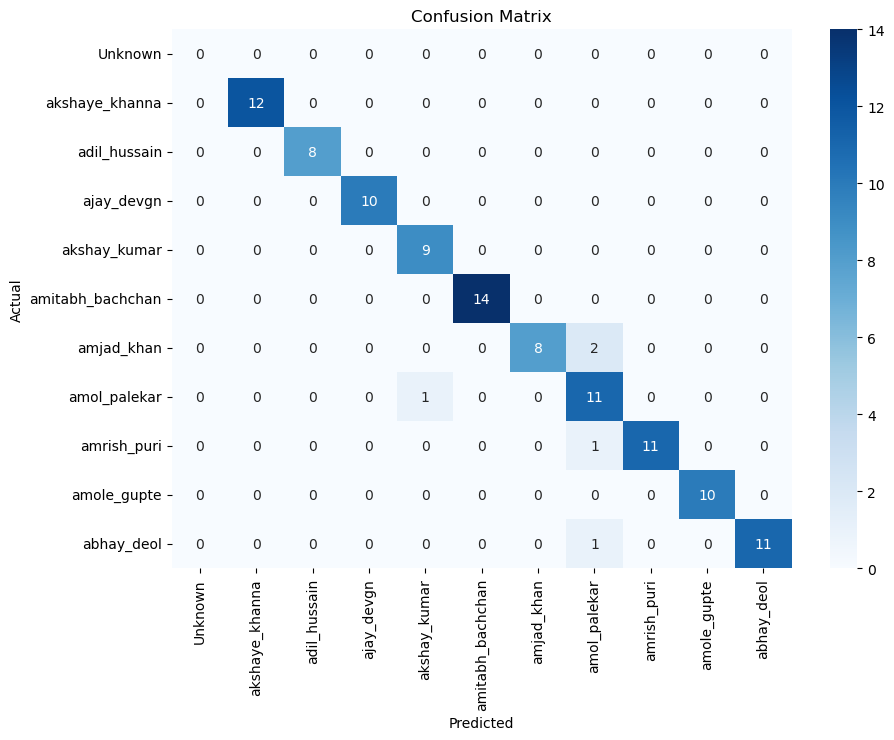

In [15]:
# Generate and display confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=list(set(train_labels + ["Unknown"])))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(train_labels + ["Unknown"])), yticklabels=list(set(train_labels + ["Unknown"])))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

                  precision    recall  f1-score   support

         Unknown       0.00      0.00      0.00         0
  akshaye_khanna       1.00      1.00      1.00        12
    adil_hussain       1.00      1.00      1.00         8
      ajay_devgn       1.00      1.00      1.00        10
    akshay_kumar       0.90      1.00      0.95         9
amitabh_bachchan       1.00      1.00      1.00        14
      amjad_khan       1.00      0.80      0.89        10
    amol_palekar       0.73      0.92      0.81        12
     amrish_puri       1.00      0.92      0.96        12
     amole_gupte       1.00      1.00      1.00        10
      abhay_deol       1.00      0.92      0.96        12

       micro avg       0.95      0.95      0.95       109
       macro avg       0.88      0.87      0.87       109
    weighted avg       0.96      0.95      0.96       109



C:\Users\Pratham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pratham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pratham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pratham\anaconda3\Lib\site

Text(0, 0.5, 'Frequency')

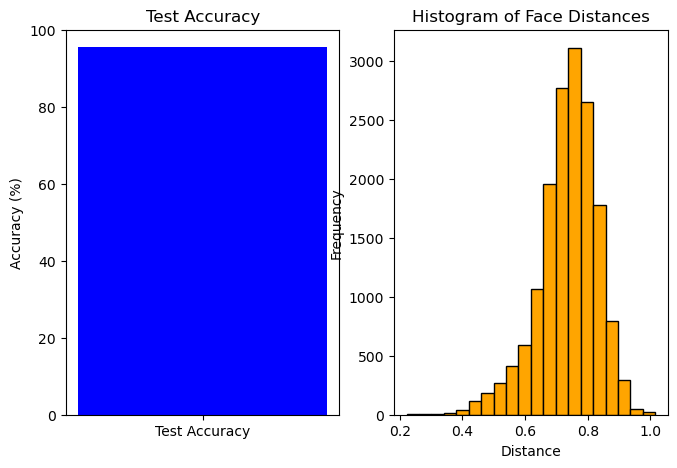

In [16]:
# Print classification report
print(classification_report(true_labels, predicted_labels, labels=list(set(train_labels + ["Unknown"]))))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.bar(['Test Accuracy'], [test_accuracy], color='blue')
plt.title('Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Plot Histogram of Distances
plt.subplot(1, 3, 2)
plt.hist(all_distances, bins=20, color='orange', edgecolor='black')
plt.title('Histogram of Face Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')

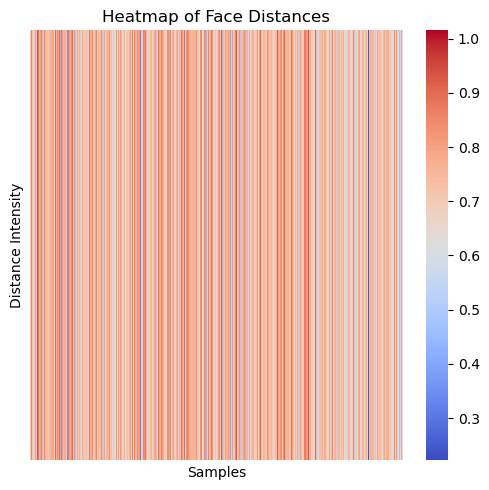

In [39]:
import seaborn as sns

# Convert distances into a 2D array (e.g., one row for visualization purposes)
distance_matrix = np.expand_dims(all_distances, axis=0)

plt.figure(figsize=(15, 5))
# Heatmap of Face Distances
plt.subplot(1, 3, 3)
sns.heatmap(distance_matrix, cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of Face Distances')
plt.xlabel('Samples')
plt.ylabel('Distance Intensity')

plt.tight_layout()
plt.show()

In [18]:
# Real-time Face Recognition
video_capture = cv2.VideoCapture(0)
print("Press 'q' to exit the live feed.")
seen_names = set()
try:
    while True:
        ret, frame = video_capture.read()
        if not ret:
            print("Failed to grab frame.")
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(rgb_frame)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

        for face_encoding, face_location in zip(face_encodings, face_locations):
            distances = face_recognition.face_distance(train_enc, face_encoding)
            best_match_index = distances.argmin()
            name = "Unknown"
            if distances[best_match_index] < 0.65:  # Adjusted threshold
                name = train_labels[best_match_index]
                if name not in seen_names:
                    mark_attendance(name)
                    seen_names.add(name)

            top, right, bottom, left = face_location
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(frame, name, (left, bottom + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        cv2.imshow('Attendance System', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    print("Webcam stopped manually.")
finally:
    video_capture.release()
    cv2.destroyAllWindows()

Press 'q' to exit the live feed.
